In [1]:
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels
import csv
import pickle

# Processing Data from PostGRES Output

Creating a single JSON file for each participant from PostGRES data that contains a single list of all participant data

In [2]:
fileprefix = "full_r_1" # pilot_[1,2,4]
datafolder = '../results/'
filepath = '{}/{}_results.json'.format(datafolder,fileprefix)


In [3]:
with open(filepath, 'r') as f:
    all_data = json.load(f)

In [4]:
part_data = {}

count = 0
for participant in all_data['values']:
    count+=1
    print(count, participant[2])
    try:
        part_object = json.loads(participant[17])
        # Update condition here by setting part_object["condition"]
        # print(part_object["condition"])
        # part_object["condition"] = 1
        part_object["Beginhit"] = participant[11]
        part_object["Beginexp"] = participant[12]
        part_object["Endhit"] = participant[13]
        part_object["psiturkStatus"] = participant[15]
        part_object["browser"] = participant[5]
        part_object["platform"] = participant[6]
        part_object["language"] = participant[7]
        
        if part_object["workerId"].startswith("debug"):
            continue

        part_data[part_object["workerId"]] = part_object
        with open('../results/{}_{}.json'.format(fileprefix, part_object['workerId']), 'w') as fw:
            json.dump(part_object, fw)
    except:
        print("Fail")
        continue;

1 611e9c16e90a0d4c6f0d8df5
2 6436d230093ad5ad76de994b
3 611f673baf2f705177f7a3c8
4 5aafd9eff69e940001d88bf4
5 614368069f5cd67c08b361ab
6 61618a4c307226e9aa6d4070
7 5a1323835d06850001b00673
8 6176b584db27cdcecc3896c8
9 614d57613ca80be2fad46361
10 5b258c9ba7cee100011d8aad
11 5e9edad6e7784d016ed87b36
12 616c024d7604234720deb5d4
13 610c39c4c8c39fd3b5a57488
14 5c92f797803bff0017fef8dd
15 debugWMvgN
16 61635ae3040c7eba5e61449f
17 debugNVdch
18 debuggdHyu
19 60daf06339ascaccef1a00932
20 60d0a2a9063606079836ba04
21 60e5ae1dabf4db8c1de4c2c4
22 6061c5e6bb5b9924d85f496a
23 61736ce99f9d835fe9eb692a
24 611d4b7415818acfe3e1857a
25 60d4869f07cdd6e3cc18fb5b
26 5e8c13d8f743d210d47ec874
27 60e0199e4a94c156a189dcd3
28 615a986463130de77f20ab15
29 611ceab3c1fd8e1d87f84f27
30 61118e2a1eba5e205800a6db
31 60e46765548980c44f6a1edc
32 60fd69d996f5348b4701313e
33 60f017cb6445630811c4bce1
34 616550455f8f691a658e06b0
35 613110abdaced6861846c409
36 60fb2cd6d4e01d29d28c7f36
37 5d4aebdd54ad1e001abee843
38 615ec038e55

In [5]:
part_data.keys()


dict_keys(['611e9c16e90a0d4c6f0d8df5', '6436d230093ad5ad76de994b', '611f673baf2f705177f7a3c8', '5aafd9eff69e940001d88bf4', '614368069f5cd67c08b361ab', '61618a4c307226e9aa6d4070', '5a1323835d06850001b00673', '6176b584db27cdcecc3896c8', '614d57613ca80be2fad46361', '5b258c9ba7cee100011d8aad', '5e9edad6e7784d016ed87b36', '616c024d7604234720deb5d4', '610c39c4c8c39fd3b5a57488', '5c92f797803bff0017fef8dd', '61635ae3040c7eba5e61449f', '60daf06339ascaccef1a00932', '60d0a2a9063606079836ba04', '60e5ae1dabf4db8c1de4c2c4', '6061c5e6bb5b9924d85f496a', '61736ce99f9d835fe9eb692a', '611d4b7415818acfe3e1857a', '60d4869f07cdd6e3cc18fb5b', '5e8c13d8f743d210d47ec874', '60e0199e4a94c156a189dcd3', '615a986463130de77f20ab15', '611ceab3c1fd8e1d87f84f27', '61118e2a1eba5e205800a6db', '60e46765548980c44f6a1edc', '60fd69d996f5348b4701313e', '60f017cb6445630811c4bce1', '616550455f8f691a658e06b0', '613110abdaced6861846c409', '60fb2cd6d4e01d29d28c7f36', '5d4aebdd54ad1e001abee843', '615ec038e5541708b1925af2', '6152f27

In [6]:
len(part_data.keys())

46

# Reading Data from Already Created Participant Data Files

In [4]:
fileprefix = "full" # pilot_#, final
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

In [5]:
part_data = {}
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
        part_data[participant["workerId"]] = participant



In [6]:
len(part_data.keys())

281

# Analyzing Trial Data

Create a list of objects, one for each participant's data

In [7]:
# List of participants who are excluded and the reason for exclusion

excluded_parts = []

In [8]:
part_stats_dicts = []
extract_max_trials = 40
for participant in part_data.values():
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    rewardsWithheld = []
    reached_max_trials = False
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    print(participant['workerId'])
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
        lastTrialStamp = participant['data'][-1]['dateTime']
    except:
        print("No data")
        continue
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    current_state = "stroop_1"
    last_trial = participant['data'][0]
    finishHITReached = False
    demographicsAvailable = False
    feedback = ""
    alreadyParticipated = ""
    comments = ""
    whatStrategy = ""
    clicksL1 = []
    firstLevelAns = {}
    clickStratsValid = True
    strategyImprove = ""
    difficult = ""
    num_correct_sequences = 0
    final_quiz_responses = None
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
        
        if participant['workerId'] == "5eb40f1f0d916d20d9db9144":
            print("{}\t{}\t{}".format(trial_type, trial_id, idx))
            
        if trial_id.startswith("mouselab_instructions_1") and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        if "num_correct_sequences" in trial['trialdata']:
            num_correct_sequences = trial['trialdata']['num_correct_sequences']
        
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            final_quiz_responses = trial['trialdata']['response']

        if trial_id.startswith("self_report_2"):
            firstLevelAns = trial['trialdata']['response']
        
        if trial_id.startswith("finish_fail"):
            feedback = trial['trialdata']['response']['Q0']
            age = trial['trialdata']['response']['Q1']
            gender = trial['trialdata']['response']['Q2']
            colorblind = trial['trialdata']['response']['Q3']
            comments = trial['trialdata']['response']['Q4']
            demographicsAvailable = True
            
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                if extract_max_trials and len(trialScores) == extract_max_trials:
                    if not reached_max_trials:
                        reached_max_trials = True
                        print(f"!!! More than {extract_max_trials} trials found !!!")
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                clicks = trial['trialdata']['queries']['click']['state']['target']
                cL1 = len([c for c in clicks if int(c) in [1,12,23]])
                clicksL1.append(cL1)
        if trial_type == 'survey-html-form':
            
            if 'effort' in trial['trialdata']['response']:
                effort = int(trial['trialdata']['response']['effort'])
                age = trial['trialdata']['response']['age']
                gender = trial['trialdata']['response']['gender']
                colorblind = trial['trialdata']['response']['colorblind']
                demographicsAvailable = True
        
        elif trial_type == 'survey-text':
            if trial_id.startswith("self_report"):
                whatStrategy = trial['trialdata']['response']['Q0']
                strategyImprove = trial['trialdata']['response']['Q1']
                difficult = trial['trialdata']['response']['Q2']
            
            elif not trial_id.startswith("answer"):
                #print(trial['trialdata'])
                feedback = trial['trialdata']['response']['Q0']
                alreadyParticipated = trial['trialdata']['response']['Q1']
                comments = trial['trialdata']['response']['Q2']
        
        if trial_type == 'html-button-response':
            if "Finish HIT" in trial['trialdata']['stimulus']:
                finishHITReached = True
        last_trial = trial
    
    # Checking if click strategies are invalid
    if firstLevelAns:
        # Criteria 1: clicks made on first level nodes on more than 10% of the trials
        madeL1Clicks = sum([bool(c) for c in clicksL1])/len(clicksL1) >= 0.10
        # Criteria 2: did not pay attention to the values at the first level - average agreement with
        #   negative statements greater than 2 (indifference)
        
        # Assessed by answers to Q5 and Q6
        possible_answers = ["Strongly disagree", "Disagree", "Neither disagree nor agree", "Agree", "Strongly agree"]
        
        # "... I did pay attention"
        scoreQ5 = possible_answers.index(firstLevelAns["Q5"])
        # "... I did NOT pay attention"
        scoreQ6 = possible_answers.index(firstLevelAns["Q6"])
        adj_scoreQ6 = len(possible_answers) - scoreQ6 - 1
        
        avg_attn_score = (scoreQ5 + adj_scoreQ6) / 2
        clickStratsValid = not madeL1Clicks or (avg_attn_score >= 2)
    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps], ["mdp"]):
        if obj["start"] > 0 and obj["end"] == 0:
            
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
    if not dropoutPoint:
        if len(trialLengths) == 0:
            dropoutPoint = "beginning"
        elif not finishHITReached:
            dropoutPoint = "finishHIT"
            
    if dropoutPoint:
        print(participant['workerId'], dropoutPoint)
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "clicksL1": clicksL1,
        "age":age,
        "colorblind":colorblind,
        "gender":gender,
        "condition": participant['condition'],
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "alreadyParticipated": alreadyParticipated,
        "comments": comments,
        "finishHITReached": finishHITReached,
        "demographicsAvailable": demographicsAvailable,
        "whatStrategy": whatStrategy,
        "strategyImprove": strategyImprove,
        "difficult": difficult,
        "firstLevelAns": firstLevelAns,
        "num_correct_sequences": num_correct_sequences,
        "final_quiz_responses": final_quiz_responses,
        "clickStratsValid": clickStratsValid
    }
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = part_stats_dict["mouselabLength"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

611e9c16e90a0d4c6f0d8df5
6436d230093ad5ad76de994b
6436d230093ad5ad76de994b mdp
611f673baf2f705177f7a3c8
5aafd9eff69e940001d88bf4
614368069f5cd67c08b361ab
61618a4c307226e9aa6d4070
5a1323835d06850001b00673
6176b584db27cdcecc3896c8
6176b584db27cdcecc3896c8 beginning
614d57613ca80be2fad46361
5b258c9ba7cee100011d8aad
5e9edad6e7784d016ed87b36
616c024d7604234720deb5d4
610c39c4c8c39fd3b5a57488
5c92f797803bff0017fef8dd
61635ae3040c7eba5e61449f
60daf06339ascaccef1a00932
60daf06339ascaccef1a00932 mdp
60d0a2a9063606079836ba04
60e5ae1dabf4db8c1de4c2c4
6061c5e6bb5b9924d85f496a
61736ce99f9d835fe9eb692a
611d4b7415818acfe3e1857a
611d4b7415818acfe3e1857a mdp
60d4869f07cdd6e3cc18fb5b
5e8c13d8f743d210d47ec874
60e0199e4a94c156a189dcd3
615a986463130de77f20ab15
615a986463130de77f20ab15 mdp
611ceab3c1fd8e1d87f84f27
611ceab3c1fd8e1d87f84f27 finishHIT
61118e2a1eba5e205800a6db
60e46765548980c44f6a1edc
60fd69d996f5348b4701313e
60f017cb6445630811c4bce1
60f017cb6445630811c4bce1 mdp
616550455f8f691a658e06b0
61655045

In [9]:
stats_df = pd.DataFrame(part_stats_dicts)
print(len(stats_df))
filter_cols = ["workerId", "Beginhit", "hitLength", "expLength", "condition", "numQuizAttempts", "numTrialsCompleted", "mouselabLength", "finalScore", "num_correct_sequences", "dropoutPoint", "finishHITReached", "psiturkStatus", "effort", "demographicsAvailable"]
stats_df[filter_cols]

45


,workerId,Beginhit,hitLength,expLength,condition,numQuizAttempts,numTrialsCompleted,mouselabLength,finalScore,num_correct_sequences,dropoutPoint,finishHITReached,psiturkStatus,effort,demographicsAvailable
0,611e9c16e90a0d4c6f0d8df5,2023-08-30 09:45:44.622733,1995.000,1982.000,1,1.0,40,1327.690,979.60,0,None,True,3,0,True
1,6436d230093ad5ad76de994b,2023-08-30 10:28:58.312786,75.050,75.050,1,1.0,0,65.930,0.00,0,mdp,False,6,-1,False
2,611f673baf2f705177f7a3c8,2023-08-30 10:16:58.944116,3690.000,3670.000,0,3.0,40,2902.777,1203.80,0,None,True,3,0,True
3,5aafd9eff69e940001d88bf4,2023-08-30 10:31:49.571984,2247.000,2233.000,1,1.0,40,1432.519,2088.90,0,None,True,3,0,True
4,614368069f5cd67c08b361ab,2023-08-30 10:33:50.351644,2074.000,2062.000,1,1.0,40,1230.895,1859.25,0,None,True,3,0,True
5,61618a4c307226e9aa6d4070,2023-08-30 10:31:06.177811,1756.000,1635.000,1,1.0,40,1114.074,9.65,0,None,True,3,0,True
6,5a1323835d06850001b00673,2023-08-30 10:51:41.020328,1765.000,1411.000,1,2.0,40,1039.279,-240.15,0,None,True,3,0,True
7,6176b584db27cdcecc3896c8,2023-08-30 10:50:35.865442,15.073,15.073,1,0.0,0,0.000,0.00,0,beginning,False,6,-1,False
8,614d57613ca80be2fad46361,2023-08-30 09:51:34.553983,4200.000,4174.000,1,3.0,40,3395.169,1858.20,0,None,True,3,0,True
9,5b258c9ba7cee100011d8aad,2023-08-30 11:45:59.367460,1386.000,1379.000,1,1.0,40,1006.406,1523.55,0,None,True,3,0,True


In [10]:
# Filter those who dropped out immediately

immediate_drops = stats_df.loc[(stats_df.dropoutPoint == "beginning")]
print(len(immediate_drops))
immediate_drops

3


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
7,6176b584db27cdcecc3896c8,2023-08-30 10:50:35.865442,NaT,2023-08-30 10:50:52.571723,6,chrome,windows,en-GB,15.073,15.073,...,,{},0,None,True,0.0,0.0,-15.073,NaN,NaN
31,613110abdaced6861846c409,2023-08-30 09:49:06.654850,NaT,2023-08-30 09:49:27.548290,6,chrome,windows,en-US,24.198,24.198,...,,{},0,None,True,0.0,0.0,-24.198,NaN,NaN
34,615ec038e5541708b1925af2,2023-08-30 09:52:20.745119,NaT,2023-08-30 09:53:18.170167,2,chrome,windows,en-US,71.025,71.025,...,,{},0,None,True,0.0,0.0,-71.025,NaN,NaN


In [11]:
for p in immediate_drops.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "dropout"
    })

In [12]:
no_immediate_drops = stats_df.loc[(stats_df.dropoutPoint != "beginning")]
print(len(no_immediate_drops))
no_immediate_drops

42


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,611e9c16e90a0d4c6f0d8df5,2023-08-30 09:45:44.622733,2023-08-30 10:19:00.410190,2023-08-30 09:45:57.715049,3,chrome,windows,en-US,1995.000,1982.000,...,it was not difficult,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,979.60,1327.690,-654.310,23303.925000,0.0
1,6436d230093ad5ad76de994b,2023-08-30 10:28:58.312786,NaT,2023-08-30 10:29:03.295832,6,safari,macos,de-DE,75.050,75.050,...,,{},0,None,True,0.00,65.930,-9.120,NaN,NaN
2,611f673baf2f705177f7a3c8,2023-08-30 10:16:58.944116,2023-08-30 11:18:29.168828,2023-08-30 10:17:18.946896,3,chrome,windows,en-US,3690.000,3670.000,...,I bit difficult. At the beginning I was gettin...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1203.80,2902.777,-767.223,36973.575000,0.0
3,5aafd9eff69e940001d88bf4,2023-08-30 10:31:49.571984,2023-08-30 11:09:16.866767,2023-08-30 10:32:03.111868,3,chrome,windows,en-US,2247.000,2233.000,...,I couldn't seem to find any pattern so that ma...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",False,2088.90,1432.519,-800.481,28068.200000,0.0
4,614368069f5cd67c08b361ab,2023-08-30 10:33:50.351644,2023-08-30 11:08:25.294971,2023-08-30 10:34:03.058870,3,chrome,windows,en-US,2074.000,2062.000,...,"It was not that difficult, but it was challeng...","{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1859.25,1230.895,-831.105,21314.675000,0.0
5,61618a4c307226e9aa6d4070,2023-08-30 10:31:06.177811,2023-08-30 11:00:22.308604,2023-08-30 10:33:07.209790,3,chrome,windows,en-US,1756.000,1635.000,...,It was not difficult after I got the hang of it,"{'Q0': 'Strongly agree', 'Q1': 'Disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,9.65,1114.074,-520.926,19712.800000,0.0
6,5a1323835d06850001b00673,2023-08-30 10:51:41.020328,2023-08-30 11:21:06.399103,2023-08-30 10:57:35.006014,3,chrome,windows,en-GB,1765.000,1411.000,...,Very difficult. It seems like it was just pure...,"{'Q0': 'Agree', 'Q1': 'Strongly disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-240.15,1039.279,-371.721,17494.375000,0.0
8,614d57613ca80be2fad46361,2023-08-30 09:51:34.553983,2023-08-30 11:01:35.197717,2023-08-30 09:52:00.838085,3,chrome,windows,en-ZA,4200.000,4174.000,...,It was not difficult since the start of the we...,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1858.20,3395.169,-778.831,43709.775000,0.0
9,5b258c9ba7cee100011d8aad,2023-08-30 11:45:59.367460,2023-08-30 12:09:05.909794,2023-08-30 11:46:06.269864,3,chrome,windows,en-US,1386.000,1379.000,...,I didn't find it difficult to improve.,"{'Q0': 'Disagree', 'Q1': 'Neither disagree nor...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1523.55,1006.406,-372.594,20444.025000,0.0
10,5e9edad6e7784d016ed87b36,2023-08-30 11:45:27.973509,2023-08-30 12:09:14.315183,2023-08-30 11:45:42.741647,3,chrome,windows,en-GB,1426.000,1411.000,...,The limited inspections meant I could only rea...,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Agree...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,612.95,917.952,-493.048,18184.750000,0.0


In [13]:
# Partial compensation rates

gbp_hourly = 6.00
secondly_rate = gbp_hourly / (3600)

In [14]:
# Early quitters - Psiturk status 6 or 2, and no quiz attempts completed

early_quitters = no_immediate_drops.loc[(no_immediate_drops.psiturkStatus == 6) & (no_immediate_drops.numQuizAttempts == 0)]
early_quitters.loc[:,'bonus'] = (early_quitters['expLength']) * secondly_rate
print(len(early_quitters))

# Printing bonuses
for idx, row in early_quitters.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']), row['condition'])
    
early_quitters

0


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus


In [15]:
for p in early_quitters.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "dropout"
    })

In [16]:
# Filtering those who failed the quiz more than 4 times

failed_quiz = no_immediate_drops.loc[(no_immediate_drops.numQuizAttempts > 0) & (no_immediate_drops.numTrialsCompleted == 0)]
failed_quiz.loc[:,'bonus'] = (failed_quiz['mouselabLength']) * secondly_rate
print(len(failed_quiz))

# Printing bonuses
for idx, row in failed_quiz.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))
failed_quiz

9
6436d230093ad5ad76de994b, 0.11
611d4b7415818acfe3e1857a, 0.19
615a986463130de77f20ab15, 0.94
60f017cb6445630811c4bce1, 0.44
616550455f8f691a658e06b0, 1.01
5d4aebdd54ad1e001abee843, 0.23
6152f27486f3558dc7e0f649, 0.26
614280ed34d0c9737fb0f796, 0.69
6102a714924dfb65fe21175b, 4.40


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_76743/3569009787.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_quiz.loc[:,'bonus'] = (failed_quiz['mouselabLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
1,6436d230093ad5ad76de994b,2023-08-30 10:28:58.312786,NaT,2023-08-30 10:29:03.295832,6,safari,macos,de-DE,75.050,75.050,...,{},0,None,True,0.0,65.930,-9.120,NaN,NaN,0.109883
20,611d4b7415818acfe3e1857a,2023-08-30 09:46:30.853385,NaT,2023-08-30 09:46:42.196594,6,chrome,windows,en-ZA,215.129,215.129,...,{},0,None,True,0.0,115.967,-99.162,NaN,NaN,0.193278
24,615a986463130de77f20ab15,2023-08-30 09:48:20.372922,NaT,2023-08-30 09:48:52.585316,6,chrome,windows,en-US,1067.963,1067.963,...,{},0,None,True,0.0,561.624,-506.339,NaN,NaN,0.936040
29,60f017cb6445630811c4bce1,2023-08-30 09:47:14.138047,NaT,2023-08-30 09:47:25.886554,6,chrome,windows,en-ZA,476.064,476.064,...,{},0,None,True,0.0,265.412,-210.652,NaN,NaN,0.442353
30,616550455f8f691a658e06b0,2023-08-30 09:49:38.651815,NaT,2023-08-30 09:49:50.586214,6,chrome,windows,en-ZA,854.380,854.380,...,{},0,None,True,0.0,603.442,-250.938,NaN,NaN,1.005737
33,5d4aebdd54ad1e001abee843,2023-08-30 09:54:57.538253,NaT,2023-08-30 10:00:21.456198,6,chrome,windows,en-US,247.292,247.292,...,{},0,None,True,0.0,139.667,-107.625,NaN,NaN,0.232778
35,6152f27486f3558dc7e0f649,2023-08-30 09:51:54.562662,NaT,2023-08-30 09:52:50.707653,6,safari,macos,xh-za,320.291,320.291,...,{},0,None,True,0.0,157.502,-162.789,NaN,NaN,0.262503
36,614280ed34d0c9737fb0f796,2023-08-30 09:51:30.118559,NaT,2023-08-30 09:51:53.882917,6,chrome,windows,en-GB,667.611,667.611,...,{},0,None,True,0.0,414.608,-253.003,NaN,NaN,0.691013
43,6102a714924dfb65fe21175b,2023-08-30 10:07:16.940259,2023-08-30 11:06:14.203584,2023-08-30 10:07:24.091696,3,chrome,windows,en-US,3537.000,3530.000,...,{},0,None,True,0.0,2639.351,-890.649,NaN,NaN,4.398918


In [17]:
failed_quiz[["workerId","numQuizAttempts", "dropoutPoint", "numTrialsCompleted"]]

,workerId,numQuizAttempts,dropoutPoint,numTrialsCompleted
1,6436d230093ad5ad76de994b,1.0,mdp,0
20,611d4b7415818acfe3e1857a,1.0,mdp,0
24,615a986463130de77f20ab15,2.0,mdp,0
29,60f017cb6445630811c4bce1,1.0,mdp,0
30,616550455f8f691a658e06b0,2.0,mdp,0
33,5d4aebdd54ad1e001abee843,1.0,mdp,0
35,6152f27486f3558dc7e0f649,1.0,mdp,0
36,614280ed34d0c9737fb0f796,2.0,mdp,0
43,6102a714924dfb65fe21175b,4.0,mdp,0


In [18]:
for idx, row in failed_quiz.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

6436d230093ad5ad76de994b	1
611d4b7415818acfe3e1857a	0
615a986463130de77f20ab15	1
60f017cb6445630811c4bce1	1
616550455f8f691a658e06b0	1
5d4aebdd54ad1e001abee843	1
6152f27486f3558dc7e0f649	0
614280ed34d0c9737fb0f796	1
6102a714924dfb65fe21175b	1


In [19]:
for p in failed_quiz.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "quizfail"
    })

In [20]:
eligible = no_immediate_drops.loc[(~no_immediate_drops['workerId'].isin(early_quitters.workerId)) & (~no_immediate_drops['workerId'].isin(failed_quiz.workerId))]
print(len(eligible))
eligible

33


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,611e9c16e90a0d4c6f0d8df5,2023-08-30 09:45:44.622733,2023-08-30 10:19:00.410190,2023-08-30 09:45:57.715049,3,chrome,windows,en-US,1995.000,1982.000,...,it was not difficult,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,979.60,1327.690,-654.310,23303.925000,0.0
2,611f673baf2f705177f7a3c8,2023-08-30 10:16:58.944116,2023-08-30 11:18:29.168828,2023-08-30 10:17:18.946896,3,chrome,windows,en-US,3690.000,3670.000,...,I bit difficult. At the beginning I was gettin...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1203.80,2902.777,-767.223,36973.575000,0.0
3,5aafd9eff69e940001d88bf4,2023-08-30 10:31:49.571984,2023-08-30 11:09:16.866767,2023-08-30 10:32:03.111868,3,chrome,windows,en-US,2247.000,2233.000,...,I couldn't seem to find any pattern so that ma...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",False,2088.90,1432.519,-800.481,28068.200000,0.0
4,614368069f5cd67c08b361ab,2023-08-30 10:33:50.351644,2023-08-30 11:08:25.294971,2023-08-30 10:34:03.058870,3,chrome,windows,en-US,2074.000,2062.000,...,"It was not that difficult, but it was challeng...","{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1859.25,1230.895,-831.105,21314.675000,0.0
5,61618a4c307226e9aa6d4070,2023-08-30 10:31:06.177811,2023-08-30 11:00:22.308604,2023-08-30 10:33:07.209790,3,chrome,windows,en-US,1756.000,1635.000,...,It was not difficult after I got the hang of it,"{'Q0': 'Strongly agree', 'Q1': 'Disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,9.65,1114.074,-520.926,19712.800000,0.0
6,5a1323835d06850001b00673,2023-08-30 10:51:41.020328,2023-08-30 11:21:06.399103,2023-08-30 10:57:35.006014,3,chrome,windows,en-GB,1765.000,1411.000,...,Very difficult. It seems like it was just pure...,"{'Q0': 'Agree', 'Q1': 'Strongly disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-240.15,1039.279,-371.721,17494.375000,0.0
8,614d57613ca80be2fad46361,2023-08-30 09:51:34.553983,2023-08-30 11:01:35.197717,2023-08-30 09:52:00.838085,3,chrome,windows,en-ZA,4200.000,4174.000,...,It was not difficult since the start of the we...,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1858.20,3395.169,-778.831,43709.775000,0.0
9,5b258c9ba7cee100011d8aad,2023-08-30 11:45:59.367460,2023-08-30 12:09:05.909794,2023-08-30 11:46:06.269864,3,chrome,windows,en-US,1386.000,1379.000,...,I didn't find it difficult to improve.,"{'Q0': 'Disagree', 'Q1': 'Neither disagree nor...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1523.55,1006.406,-372.594,20444.025000,0.0
10,5e9edad6e7784d016ed87b36,2023-08-30 11:45:27.973509,2023-08-30 12:09:14.315183,2023-08-30 11:45:42.741647,3,chrome,windows,en-GB,1426.000,1411.000,...,The limited inspections meant I could only rea...,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Agree...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,612.95,917.952,-493.048,18184.750000,0.0
11,616c024d7604234720deb5d4,2023-08-30 09:51:36.295232,2023-08-30 10:23:22.036504,2023-08-30 09:52:02.376485,3,chrome,windows,en-US,1905.000,1879.000,...,It was difficult as I can never be sure of the...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-165.00,1343.650,-535.350,18075.675000,0.0


In [21]:
data_actually_complete = []

In [22]:
incomplete_data = eligible.loc[(eligible.psiturkStatus != 3) & (~eligible.workerId.isin(data_actually_complete))]
print(len(incomplete_data))
incomplete_data[["workerId", "numTrialsCompleted", "dropoutPoint", "demographicsAvailable"]]

4


,workerId,numTrialsCompleted,dropoutPoint,demographicsAvailable
15,60daf06339ascaccef1a00932,1,mdp,False
25,611ceab3c1fd8e1d87f84f27,40,finishHIT,False
38,59d9cea2e2762800015eb791,32,mdp,False
41,5891dd715c15e00001583fbc,30,mdp,False


In [23]:
for idx, row in incomplete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

6483247637d20bcecd41963b	1
611d2f96b140246f8f2d18bc	0
60dc31374fc70253e7a2d9e9	1
61693a88caa235cc1209b3ca	1
5e0df69e6f6d3e5342ba6d24	0
5e4e6e53f4bdd82b601f2e9a	0
61688ab804063e6cec34cec6	1
60c620563db55cd06f3772fa	1
64a95992344c4b935674d28e	0
612530f3e28f8c909170bf0a	1
610b27ac93b71d55da6f6233	0


In [23]:

incomplete_full_compensation_eligible = []
incomplete_partial_compensation_eligible = ["59d9cea2e2762800015eb791", "5891dd715c15e00001583fbc", "611ceab3c1fd8e1d87f84f27"]


In [24]:
incomplete_partial = eligible.loc[(eligible.workerId.isin(incomplete_partial_compensation_eligible))]
incomplete_partial.loc[:,'bonus'] = (incomplete_partial['mouselabLength']) * secondly_rate
print(len(incomplete_partial))

# Printing bonuses
for idx, row in incomplete_partial.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))#, row['condition'])
incomplete_partial

3
611ceab3c1fd8e1d87f84f27, 3.85
59d9cea2e2762800015eb791, 1.42
5891dd715c15e00001583fbc, 1.79


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_76743/550307939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incomplete_partial.loc[:,'bonus'] = (incomplete_partial['mouselabLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
25,611ceab3c1fd8e1d87f84f27,2023-08-30 09:48:31.883273,NaT,2023-08-30 09:48:42.371056,2,chrome,windows,en-US,2656.348,2656.348,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,-312.20,2307.525,-348.823,21822.825000,0.0,3.845875
38,59d9cea2e2762800015eb791,2023-08-30 10:07:03.566505,NaT,2023-08-30 10:07:09.935958,6,safari,macos,en-GB,1173.556,1173.556,...,{},0,None,True,35.10,854.837,-318.719,19365.781250,0.0,1.424728
41,5891dd715c15e00001583fbc,2023-08-30 09:52:04.524421,NaT,2023-08-30 09:52:11.718860,6,safari,macos,en-gb,1369.851,1369.851,...,{},0,None,True,902.05,1073.593,-296.258,25838.166667,0.0,1.789322


In [25]:
for p in incomplete_data.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "dataincomplete"
    })

In [26]:
# Participant data that is complete

complete_data = eligible.loc[(eligible.psiturkStatus == 3) | (eligible.workerId.isin(data_actually_complete))]
print(len(complete_data.loc[complete_data.condition == 0]))
print(len(complete_data.loc[complete_data.condition == 1]))
#print(len(complete_data.loc[complete_data.condition == 2]))
complete_data

15
14


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,611e9c16e90a0d4c6f0d8df5,2023-08-30 09:45:44.622733,2023-08-30 10:19:00.410190,2023-08-30 09:45:57.715049,3,chrome,windows,en-US,1995.0,1982.0,...,it was not difficult,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,979.60,1327.690,-654.310,23303.925,0.0
2,611f673baf2f705177f7a3c8,2023-08-30 10:16:58.944116,2023-08-30 11:18:29.168828,2023-08-30 10:17:18.946896,3,chrome,windows,en-US,3690.0,3670.0,...,I bit difficult. At the beginning I was gettin...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1203.80,2902.777,-767.223,36973.575,0.0
3,5aafd9eff69e940001d88bf4,2023-08-30 10:31:49.571984,2023-08-30 11:09:16.866767,2023-08-30 10:32:03.111868,3,chrome,windows,en-US,2247.0,2233.0,...,I couldn't seem to find any pattern so that ma...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",False,2088.90,1432.519,-800.481,28068.200,0.0
4,614368069f5cd67c08b361ab,2023-08-30 10:33:50.351644,2023-08-30 11:08:25.294971,2023-08-30 10:34:03.058870,3,chrome,windows,en-US,2074.0,2062.0,...,"It was not that difficult, but it was challeng...","{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1859.25,1230.895,-831.105,21314.675,0.0
5,61618a4c307226e9aa6d4070,2023-08-30 10:31:06.177811,2023-08-30 11:00:22.308604,2023-08-30 10:33:07.209790,3,chrome,windows,en-US,1756.0,1635.0,...,It was not difficult after I got the hang of it,"{'Q0': 'Strongly agree', 'Q1': 'Disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,9.65,1114.074,-520.926,19712.800,0.0
6,5a1323835d06850001b00673,2023-08-30 10:51:41.020328,2023-08-30 11:21:06.399103,2023-08-30 10:57:35.006014,3,chrome,windows,en-GB,1765.0,1411.0,...,Very difficult. It seems like it was just pure...,"{'Q0': 'Agree', 'Q1': 'Strongly disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-240.15,1039.279,-371.721,17494.375,0.0
8,614d57613ca80be2fad46361,2023-08-30 09:51:34.553983,2023-08-30 11:01:35.197717,2023-08-30 09:52:00.838085,3,chrome,windows,en-ZA,4200.0,4174.0,...,It was not difficult since the start of the we...,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1858.20,3395.169,-778.831,43709.775,0.0
9,5b258c9ba7cee100011d8aad,2023-08-30 11:45:59.367460,2023-08-30 12:09:05.909794,2023-08-30 11:46:06.269864,3,chrome,windows,en-US,1386.0,1379.0,...,I didn't find it difficult to improve.,"{'Q0': 'Disagree', 'Q1': 'Neither disagree nor...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1523.55,1006.406,-372.594,20444.025,0.0
10,5e9edad6e7784d016ed87b36,2023-08-30 11:45:27.973509,2023-08-30 12:09:14.315183,2023-08-30 11:45:42.741647,3,chrome,windows,en-GB,1426.0,1411.0,...,The limited inspections meant I could only rea...,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Agree...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,612.95,917.952,-493.048,18184.750,0.0
11,616c024d7604234720deb5d4,2023-08-30 09:51:36.295232,2023-08-30 10:23:22.036504,2023-08-30 09:52:02.376485,3,chrome,windows,en-US,1905.0,1879.0,...,It was difficult as I can never be sure of the...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-165.00,1343.650,-535.350,18075.675,0.0


In [27]:
for idx, row in complete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

611e9c16e90a0d4c6f0d8df5	1
611f673baf2f705177f7a3c8	0
5aafd9eff69e940001d88bf4	1
614368069f5cd67c08b361ab	1
61618a4c307226e9aa6d4070	1
5a1323835d06850001b00673	1
614d57613ca80be2fad46361	1
5b258c9ba7cee100011d8aad	1
5e9edad6e7784d016ed87b36	1
616c024d7604234720deb5d4	0
610c39c4c8c39fd3b5a57488	1
5c92f797803bff0017fef8dd	0
61635ae3040c7eba5e61449f	0
60d0a2a9063606079836ba04	0
60e5ae1dabf4db8c1de4c2c4	1
6061c5e6bb5b9924d85f496a	0
61736ce99f9d835fe9eb692a	0
60d4869f07cdd6e3cc18fb5b	0
5e8c13d8f743d210d47ec874	0
60e0199e4a94c156a189dcd3	1
61118e2a1eba5e205800a6db	1
60e46765548980c44f6a1edc	0
60fd69d996f5348b4701313e	1
60fb2cd6d4e01d29d28c7f36	1
6130ed04f8c4d5153c9b466a	0
64ac208fdf83b16f16621dcb	0
60da0dd4c8268e2d7125907e	0
5fe24f4dcb7697decd41db77	0
63e96aac1a64f6442aeadf72	0


In [28]:
# Participants eligible for full bonus

full_bonus_eligible = pd.concat([complete_data, eligible.loc[eligible.workerId.isin(incomplete_full_compensation_eligible)]])

print(len(full_bonus_eligible))
full_bonus_eligible

29


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,611e9c16e90a0d4c6f0d8df5,2023-08-30 09:45:44.622733,2023-08-30 10:19:00.410190,2023-08-30 09:45:57.715049,3,chrome,windows,en-US,1995.0,1982.0,...,it was not difficult,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,979.60,1327.690,-654.310,23303.925,0.0
2,611f673baf2f705177f7a3c8,2023-08-30 10:16:58.944116,2023-08-30 11:18:29.168828,2023-08-30 10:17:18.946896,3,chrome,windows,en-US,3690.0,3670.0,...,I bit difficult. At the beginning I was gettin...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1203.80,2902.777,-767.223,36973.575,0.0
3,5aafd9eff69e940001d88bf4,2023-08-30 10:31:49.571984,2023-08-30 11:09:16.866767,2023-08-30 10:32:03.111868,3,chrome,windows,en-US,2247.0,2233.0,...,I couldn't seem to find any pattern so that ma...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",False,2088.90,1432.519,-800.481,28068.200,0.0
4,614368069f5cd67c08b361ab,2023-08-30 10:33:50.351644,2023-08-30 11:08:25.294971,2023-08-30 10:34:03.058870,3,chrome,windows,en-US,2074.0,2062.0,...,"It was not that difficult, but it was challeng...","{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1859.25,1230.895,-831.105,21314.675,0.0
5,61618a4c307226e9aa6d4070,2023-08-30 10:31:06.177811,2023-08-30 11:00:22.308604,2023-08-30 10:33:07.209790,3,chrome,windows,en-US,1756.0,1635.0,...,It was not difficult after I got the hang of it,"{'Q0': 'Strongly agree', 'Q1': 'Disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,9.65,1114.074,-520.926,19712.800,0.0
6,5a1323835d06850001b00673,2023-08-30 10:51:41.020328,2023-08-30 11:21:06.399103,2023-08-30 10:57:35.006014,3,chrome,windows,en-GB,1765.0,1411.0,...,Very difficult. It seems like it was just pure...,"{'Q0': 'Agree', 'Q1': 'Strongly disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-240.15,1039.279,-371.721,17494.375,0.0
8,614d57613ca80be2fad46361,2023-08-30 09:51:34.553983,2023-08-30 11:01:35.197717,2023-08-30 09:52:00.838085,3,chrome,windows,en-ZA,4200.0,4174.0,...,It was not difficult since the start of the we...,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1858.20,3395.169,-778.831,43709.775,0.0
9,5b258c9ba7cee100011d8aad,2023-08-30 11:45:59.367460,2023-08-30 12:09:05.909794,2023-08-30 11:46:06.269864,3,chrome,windows,en-US,1386.0,1379.0,...,I didn't find it difficult to improve.,"{'Q0': 'Disagree', 'Q1': 'Neither disagree nor...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1523.55,1006.406,-372.594,20444.025,0.0
10,5e9edad6e7784d016ed87b36,2023-08-30 11:45:27.973509,2023-08-30 12:09:14.315183,2023-08-30 11:45:42.741647,3,chrome,windows,en-GB,1426.0,1411.0,...,The limited inspections meant I could only rea...,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Agree...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,612.95,917.952,-493.048,18184.750,0.0
11,616c024d7604234720deb5d4,2023-08-30 09:51:36.295232,2023-08-30 10:23:22.036504,2023-08-30 09:52:02.376485,3,chrome,windows,en-US,1905.0,1879.0,...,It was difficult as I can never be sure of the...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-165.00,1343.650,-535.350,18075.675,0.0


In [29]:
#full_bonus_eligible.loc[full_bonus_eligible.workerId == "5f6214a59413141f7cb2508c"]

In [30]:
# Calculating the bonus conversion rate for each condition

max_bonus = 1.5

fix_bonus_rate = True
fixed_bonus_rate = 0.000833


bonus_calc_cols = ["condition", "finalScore"]

bonus_rate = {}

for condition in np.unique(full_bonus_eligible.condition):
    if not fix_bonus_rate:
        bonus_rate[condition] = max_bonus / full_bonus_eligible.loc[full_bonus_eligible.condition == condition].finalScore.max()
    else:
        bonus_rate[condition] = fixed_bonus_rate

# stats_df_filtered = stats_df.loc[stats_df['numTrialsCompleted'] > 0]

bonuses = []
# Adding the bonus for each participant
for idx, row in full_bonus_eligible.iterrows():
    bonuses.append(bonus_rate[row['condition']] * row['finalScore'])

full_bonus_eligible['bonus'] = bonuses
full_bonus_eligible

,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
0,611e9c16e90a0d4c6f0d8df5,2023-08-30 09:45:44.622733,2023-08-30 10:19:00.410190,2023-08-30 09:45:57.715049,3,chrome,windows,en-US,1995.0,1982.0,...,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,979.60,1327.690,-654.310,23303.925,0.0,0.816007
2,611f673baf2f705177f7a3c8,2023-08-30 10:16:58.944116,2023-08-30 11:18:29.168828,2023-08-30 10:17:18.946896,3,chrome,windows,en-US,3690.0,3670.0,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1203.80,2902.777,-767.223,36973.575,0.0,1.002765
3,5aafd9eff69e940001d88bf4,2023-08-30 10:31:49.571984,2023-08-30 11:09:16.866767,2023-08-30 10:32:03.111868,3,chrome,windows,en-US,2247.0,2233.0,...,"{'Q0': 'Strongly disagree', 'Q1': 'Neither dis...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",False,2088.90,1432.519,-800.481,28068.200,0.0,1.740054
4,614368069f5cd67c08b361ab,2023-08-30 10:33:50.351644,2023-08-30 11:08:25.294971,2023-08-30 10:34:03.058870,3,chrome,windows,en-US,2074.0,2062.0,...,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1859.25,1230.895,-831.105,21314.675,0.0,1.548755
5,61618a4c307226e9aa6d4070,2023-08-30 10:31:06.177811,2023-08-30 11:00:22.308604,2023-08-30 10:33:07.209790,3,chrome,windows,en-US,1756.0,1635.0,...,"{'Q0': 'Strongly agree', 'Q1': 'Disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,9.65,1114.074,-520.926,19712.800,0.0,0.008038
6,5a1323835d06850001b00673,2023-08-30 10:51:41.020328,2023-08-30 11:21:06.399103,2023-08-30 10:57:35.006014,3,chrome,windows,en-GB,1765.0,1411.0,...,"{'Q0': 'Agree', 'Q1': 'Strongly disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-240.15,1039.279,-371.721,17494.375,0.0,-0.200045
8,614d57613ca80be2fad46361,2023-08-30 09:51:34.553983,2023-08-30 11:01:35.197717,2023-08-30 09:52:00.838085,3,chrome,windows,en-ZA,4200.0,4174.0,...,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1858.20,3395.169,-778.831,43709.775,0.0,1.547881
9,5b258c9ba7cee100011d8aad,2023-08-30 11:45:59.367460,2023-08-30 12:09:05.909794,2023-08-30 11:46:06.269864,3,chrome,windows,en-US,1386.0,1379.0,...,"{'Q0': 'Disagree', 'Q1': 'Neither disagree nor...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1523.55,1006.406,-372.594,20444.025,0.0,1.269117
10,5e9edad6e7784d016ed87b36,2023-08-30 11:45:27.973509,2023-08-30 12:09:14.315183,2023-08-30 11:45:42.741647,3,chrome,windows,en-GB,1426.0,1411.0,...,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Agree...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,612.95,917.952,-493.048,18184.750,0.0,0.510587
11,616c024d7604234720deb5d4,2023-08-30 09:51:36.295232,2023-08-30 10:23:22.036504,2023-08-30 09:52:02.376485,3,chrome,windows,en-US,1905.0,1879.0,...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-165.00,1343.650,-535.350,18075.675,0.0,-0.137445


In [31]:
# Bonus rates

bonus_rate

{0: 0.000833, 1: 0.000833}

In [54]:
print_bonuses = True

p_list = []
# Printing completed IDs for approval + bonuses
for idx, row in full_bonus_eligible.iterrows():
    p_list.append(row['workerId'])
    if not print_bonuses:
        print('{0}'.format(row['workerId']))
    else:
        if(row['bonus'] > 0):
            print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))


611e9c16e90a0d4c6f0d8df5, 0.82
611f673baf2f705177f7a3c8, 1.00
5aafd9eff69e940001d88bf4, 1.74
614368069f5cd67c08b361ab, 1.55
61618a4c307226e9aa6d4070, 0.01
614d57613ca80be2fad46361, 1.55
5b258c9ba7cee100011d8aad, 1.27
5e9edad6e7784d016ed87b36, 0.51
610c39c4c8c39fd3b5a57488, 1.86
5c92f797803bff0017fef8dd, 1.36
61635ae3040c7eba5e61449f, 0.04
60e5ae1dabf4db8c1de4c2c4, 1.37
6061c5e6bb5b9924d85f496a, 1.21
60d4869f07cdd6e3cc18fb5b, 1.56
5e8c13d8f743d210d47ec874, 1.30
60e0199e4a94c156a189dcd3, 0.58
61118e2a1eba5e205800a6db, 0.23
60e46765548980c44f6a1edc, 0.67
60fd69d996f5348b4701313e, 1.51
60fb2cd6d4e01d29d28c7f36, 0.02
6130ed04f8c4d5153c9b466a, 1.62
64ac208fdf83b16f16621dcb, 1.34
5fe24f4dcb7697decd41db77, 1.74
63e96aac1a64f6442aeadf72, 1.66


In [33]:
# Average bonus

print(full_bonus_eligible["bonus"].mean())
print(full_bonus_eligible["bonus"].std())

0.8695098155172414
0.7557481283444816



Condition: 0
Mean: 33.47888888888889
Std: 10.677612439464518
Median: 31.316666666666666

Condition: 1
Mean: 33.898809523809526
Std: 12.058193058716126
Median: 32.825


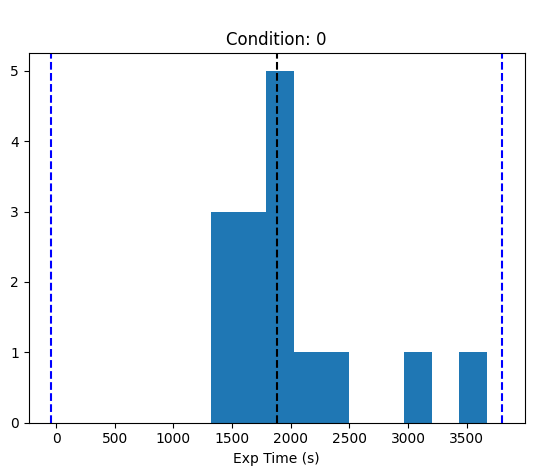

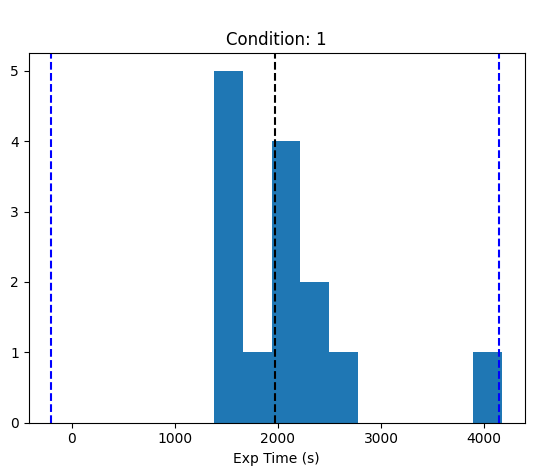

In [36]:
# Time taken per condition

exceeded_parts = []

for condition in [0,1]:
    print("\nCondition: " +str(condition))
    condition_df = complete_data.loc[complete_data.condition == condition]
    clength = condition_df.expLength
    mean = clength.mean()
    sd = clength.std()
    med = clength.median()
    print("Mean: " + str(mean/60))
    print("Std: " + str(sd/60))
    print("Median: " + str(med/60))
    
    time_exceed_df = condition_df.loc[(condition_df.expLength > med + 3*sd) | (condition_df.expLength < med - 3*sd)]
    exceeded_parts += list(time_exceed_df.workerId)
    
    plt.figure()
    plt.hist(clength)
    plt.axvline(med, linestyle='--', color='black')
    plt.axvline(med + 3*sd, linestyle='--', color='blue')
    plt.axvline(med - 3*sd, linestyle='--', color='blue')
    plt.title("\nCondition: " +str(condition))
    plt.xlabel("Exp Time (s)")
    
plt.show()


In [37]:
# Excluding participants based on time

within_time_parts = complete_data.loc[~complete_data.workerId.isin(exceeded_parts)]
print(len(within_time_parts.loc[within_time_parts.condition == 0]))
print(len(within_time_parts.loc[within_time_parts.condition == 1]))
print("\n")
for part in exceeded_parts:
    print(part, list(complete_data.loc[complete_data.workerId == part]["condition"])[0])

15
13


614d57613ca80be2fad46361 1


In [38]:
for p in exceeded_parts:
    excluded_parts.append({
        "workerId": p,
        "reason": "exceededTime"
    })

In [39]:
# Excluding participants based on effort
ineffortful_parts = within_time_parts.loc[within_time_parts.effort > 1]
ineffortful_parts[["workerId", "condition", "effort"]]


,workerId,condition,effort


In [40]:
effortful_parts = within_time_parts.loc[~within_time_parts.workerId.isin(list(ineffortful_parts.workerId))]
print(len(effortful_parts.loc[effortful_parts.condition == 0]))
print(len(effortful_parts.loc[effortful_parts.condition == 1]))


15
13


In [41]:
for p in ineffortful_parts.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "noeffort"
    })

In [42]:
# Excluding participants who already have done the task
for idx, (workerId, ans) in effortful_parts[["workerId","alreadyParticipated"]].iterrows():
    if "no" not in ans.lower() and "never" not in ans.lower():
        print(workerId, ans)

5e9edad6e7784d016ed87b36 I haven't done this before, first timer!
5c92f797803bff0017fef8dd I didn't realise that because this is my first time.


In [43]:
# Already participated have to be filtered manually

already_participated_ids = []

already_participated = effortful_parts.loc[effortful_parts.workerId.isin(already_participated_ids)]
already_participated[["workerId", "condition"]]

,workerId,condition


In [44]:
for p in already_participated.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "alreadyparticipated"
    })

In [45]:
new_parts = effortful_parts.loc[~effortful_parts.workerId.isin(already_participated_ids)]
print(len(new_parts.loc[new_parts.condition == 0]))
print(len(new_parts.loc[new_parts.condition == 1]))

15
13


In [46]:
# Participant data that is complete and that also has valid click strategies 

valid_click_strat_data = new_parts.loc[new_parts.clickStratsValid]
print(len(valid_click_strat_data.loc[valid_click_strat_data.condition == 0]))
print(len(valid_click_strat_data.loc[valid_click_strat_data.condition == 1]))
#print(len(complete_data.loc[complete_data.condition == 2]))
valid_click_strat_data

15
12


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,clickStratsValid,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,611e9c16e90a0d4c6f0d8df5,2023-08-30 09:45:44.622733,2023-08-30 10:19:00.410190,2023-08-30 09:45:57.715049,3,chrome,windows,en-US,1995.0,1982.0,...,it was not difficult,"{'Q0': 'Neither disagree nor agree', 'Q1': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,979.60,1327.690,-654.310,23303.925,0.0
2,611f673baf2f705177f7a3c8,2023-08-30 10:16:58.944116,2023-08-30 11:18:29.168828,2023-08-30 10:17:18.946896,3,chrome,windows,en-US,3690.0,3670.0,...,I bit difficult. At the beginning I was gettin...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1203.80,2902.777,-767.223,36973.575,0.0
4,614368069f5cd67c08b361ab,2023-08-30 10:33:50.351644,2023-08-30 11:08:25.294971,2023-08-30 10:34:03.058870,3,chrome,windows,en-US,2074.0,2062.0,...,"It was not that difficult, but it was challeng...","{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Ag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,1859.25,1230.895,-831.105,21314.675,0.0
5,61618a4c307226e9aa6d4070,2023-08-30 10:31:06.177811,2023-08-30 11:00:22.308604,2023-08-30 10:33:07.209790,3,chrome,windows,en-US,1756.0,1635.0,...,It was not difficult after I got the hang of it,"{'Q0': 'Strongly agree', 'Q1': 'Disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,9.65,1114.074,-520.926,19712.800,0.0
6,5a1323835d06850001b00673,2023-08-30 10:51:41.020328,2023-08-30 11:21:06.399103,2023-08-30 10:57:35.006014,3,chrome,windows,en-GB,1765.0,1411.0,...,Very difficult. It seems like it was just pure...,"{'Q0': 'Agree', 'Q1': 'Strongly disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-240.15,1039.279,-371.721,17494.375,0.0
9,5b258c9ba7cee100011d8aad,2023-08-30 11:45:59.367460,2023-08-30 12:09:05.909794,2023-08-30 11:46:06.269864,3,chrome,windows,en-US,1386.0,1379.0,...,I didn't find it difficult to improve.,"{'Q0': 'Disagree', 'Q1': 'Neither disagree nor...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,1523.55,1006.406,-372.594,20444.025,0.0
10,5e9edad6e7784d016ed87b36,2023-08-30 11:45:27.973509,2023-08-30 12:09:14.315183,2023-08-30 11:45:42.741647,3,chrome,windows,en-GB,1426.0,1411.0,...,The limited inspections meant I could only rea...,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Agree...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",True,612.95,917.952,-493.048,18184.750,0.0
11,616c024d7604234720deb5d4,2023-08-30 09:51:36.295232,2023-08-30 10:23:22.036504,2023-08-30 09:52:02.376485,3,chrome,windows,en-US,1905.0,1879.0,...,It was difficult as I can never be sure of the...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",True,-165.00,1343.650,-535.350,18075.675,0.0
12,610c39c4c8c39fd3b5a57488,2023-08-30 11:45:47.753031,2023-08-30 12:09:27.846117,2023-08-30 11:45:55.855097,3,firefox,windows,en-US,1420.0,1411.0,...,remembering the numbers,"{'Q0': 'Disagree', 'Q1': 'Neither disagree nor...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",True,2231.70,1141.847,-269.153,24668.075,0.0
13,5c92f797803bff0017fef8dd,2023-08-30 11:46:00.479362,2023-08-30 12:09:58.460811,2023-08-30 11:46:07.630719,3,chrome,windows,en-GB,1437.0,1430.0,...,It wasn't difficult.,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-4 to $4', 'Q2': ...",True,1635.00,975.717,-454.283,20429.400,0.0


In [47]:
# Excluding participants

invalid_click_strat_data = new_parts.loc[~new_parts.clickStratsValid]
for p in invalid_click_strat_data.workerId:
    excluded_parts.append({
        "workerId": p,
        "reason": "invalidClickStrats"
    })

In [48]:
# Final score per condition

for condition in [0,1,2]:
    print("\nCondition: " +str(condition))
    clength = new_parts.loc[new_parts.condition == condition].finalScore
    print("Mean: " + str(clength.mean()))
    print("Std: " + str(clength.std()))
    print("Median: " + str(clength.median()))


Condition: 0
Mean: 993.3333333333335
Std: 975.8274544981715
Median: 1449.0

Condition: 1
Mean: 1039.45
Std: 866.7163881570488
Median: 979.6

Condition: 2
Mean: nan
Std: nan
Median: nan


In [51]:
# Updating all files of participants whose data should be excluded

for ep in excluded_parts:
    w = ep["workerId"]
    # Get the file name 
    file = [fn for fn in os.listdir(datafolder) if w in fn][0]
    fpath = datafolder + file
    # Read the json
    with open(fpath, 'r') as f:
        participant = json.load(f)
    # Add the fields
    participant["excludeReason"] = ep["reason"]
    # Rewrite the file
    with open(fpath, 'w') as fw:
        json.dump(participant, fw)
    print(f"Wrote to {file}: {ep['reason']}")
    
    

Wrote to full_r_1_6176b584db27cdcecc3896c8.json: dropout
Wrote to full_r_1_613110abdaced6861846c409.json: dropout
Wrote to full_r_1_615ec038e5541708b1925af2.json: dropout
Wrote to full_r_1_6436d230093ad5ad76de994b.json: quizfail
Wrote to full_r_1_611d4b7415818acfe3e1857a.json: quizfail
Wrote to full_r_1_615a986463130de77f20ab15.json: quizfail
Wrote to full_r_1_60f017cb6445630811c4bce1.json: quizfail
Wrote to full_r_1_616550455f8f691a658e06b0.json: quizfail
Wrote to full_r_1_5d4aebdd54ad1e001abee843.json: quizfail
Wrote to full_r_1_6152f27486f3558dc7e0f649.json: quizfail
Wrote to full_r_1_614280ed34d0c9737fb0f796.json: quizfail
Wrote to full_r_1_6102a714924dfb65fe21175b.json: quizfail
Wrote to full_r_1_60daf06339ascaccef1a00932.json: dataincomplete
Wrote to full_r_1_611ceab3c1fd8e1d87f84f27.json: dataincomplete
Wrote to full_r_1_59d9cea2e2762800015eb791.json: dataincomplete
Wrote to full_r_1_5891dd715c15e00001583fbc.json: dataincomplete
Wrote to full_r_1_614d57613ca80be2fad46361.json: e

In [52]:
sorted(list(new_parts.workerId))

['5a1323835d06850001b00673',
 '5aafd9eff69e940001d88bf4',
 '5b258c9ba7cee100011d8aad',
 '5c92f797803bff0017fef8dd',
 '5e8c13d8f743d210d47ec874',
 '5e9edad6e7784d016ed87b36',
 '5fe24f4dcb7697decd41db77',
 '6061c5e6bb5b9924d85f496a',
 '60d0a2a9063606079836ba04',
 '60d4869f07cdd6e3cc18fb5b',
 '60da0dd4c8268e2d7125907e',
 '60e0199e4a94c156a189dcd3',
 '60e46765548980c44f6a1edc',
 '60e5ae1dabf4db8c1de4c2c4',
 '60fb2cd6d4e01d29d28c7f36',
 '60fd69d996f5348b4701313e',
 '610c39c4c8c39fd3b5a57488',
 '61118e2a1eba5e205800a6db',
 '611e9c16e90a0d4c6f0d8df5',
 '611f673baf2f705177f7a3c8',
 '6130ed04f8c4d5153c9b466a',
 '614368069f5cd67c08b361ab',
 '61618a4c307226e9aa6d4070',
 '61635ae3040c7eba5e61449f',
 '616c024d7604234720deb5d4',
 '61736ce99f9d835fe9eb692a',
 '63e96aac1a64f6442aeadf72',
 '64ac208fdf83b16f16621dcb']

# Creating CSV for MCL Toolbox

Converting participant data into a CSV format that is appropriate for reading by mcl_toolbox models

In [88]:
s = "pid,trial_index,action_time,actions,block,path,queries,reward,rt,condition,bonus,score,simulation_mode,state_rewards,time_elapsed,trialTime,trial_type"

for h in s.split(","):
    print("\"{}\",".format(h))

"pid",
"trial_index",
"action_time",
"actions",
"block",
"path",
"queries",
"reward",
"rt",
"condition",
"bonus",
"score",
"simulation_mode",
"state_rewards",
"time_elapsed",
"trialTime",
"trial_type",


In [89]:
header_row = [
    "pid",
    "trial_index",
    "action_time",
    "actions",
    "block",
    "path",
    "queries",
    "reward",
    "rt",
    "condition",
    "bonus",
    "score",
    "simulation_mode",
    "state_rewards",
    "time_elapsed",
    "trialTime",
    "trial_type",
    "reward_withheld"
]


In [90]:
scarce_complete = complete_data[complete_data.condition == 1]
control_complete = complete_data[complete_data.condition == 0]


control_csv_rows = [header_row]
scarce_csv_rows = [header_row]

# Create a CSV table with all the trials as rows
for workerId in complete_data.workerId:
    # Read data as was present in PostGRES output
    # Part_data object created at very beginning of this notebook
    participant = part_data[workerId]
    trial_count = 1
    click_cost = participant["condition"] * 0.25 + (1 - participant["condition"])
    for idx, data_point in enumerate(participant["data"]):
        trialdata = data_point["trialdata"]
        if trialdata["trial_type"] == "mouselab-mdp" and trialdata["trial_id"].startswith("mdp_"):
            if trial_count > 40: 
                print(workerId)
                continue
            num_clicks = len(trialdata["queries"]["click"]["state"]["target"])
            new_row = [
                workerId,
                trial_count,
                trialdata["actionTimes"],
                trialdata["actions"],
                "begin" if trial_count <= 10 else "test",
                trialdata["path"],
                trialdata["queries"],
                trialdata["rewards"],
                trialdata["rt"],
                participant["condition"],
                0,
                trialdata["score"],
                [None] * 3,
                trialdata["stateRewards"],
                trialdata["time_elapsed"],
                trialdata["trialTime"],
                trialdata["trial_type"],
                trialdata["withholdReward"]
            ]
            trial_count += 1
            # print(click_cost, num_clicks, trialdata["score"], new_row[11], new_row[-1])
            if participant["condition"] == 0:
                control_csv_rows.append(new_row)
            else:
                scarce_csv_rows.append(new_row)
    
    

64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1
64835cdc41f91285bcbd2de1


In [81]:
# Write to CSV file

with open('../results/mouselab-mdp-final-misaligned.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in scarce_csv_rows:
        writer.writerow(row)


In [91]:
# Write to CSV file

with open('../results/mouselab-mdp-final-control.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in control_csv_rows:
        writer.writerow(row)


In [8]:
# Creating CSV for optimal strategy to infer sequences

optimalpicklename = "../results/1.0_clicks_high_increasing_.pickle"

with open(optimalpicklename, 'rb') as file:
    optimal_clicks = pickle.load(file)
    
opt_csv_rows = [header_row]

trial_count = 1

for trial in optimal_clicks["optimal"]:
    trial_rewards = [trial["stateRewards"][int(c)] for c in trial["clicks"][:-1]]
    new_row = [
        "dynamic_program",
        trial_count,
        [],
        [],
        "begin" if trial_count <= 10 else "test",
        [],
        { 
            "click" : { 
                "state" : {
                    "target" : trial["clicks"][:-1],
                    "times" : list(range(len(trial["clicks"][:-1])))
                }
            }
        },
        trial_rewards,
        [3] * len(trial["clicks"][:-1]),
        0,
        0,
        0,
        [None] * 3,
        trial["stateRewards"],
        None,
        None,
        "mouselab-mdp"

    ]
    trial_count += 1
    opt_csv_rows.append(new_row)
    if trial_count == 31: 
        break

In [9]:
# Write to CSV file

with open('../results/mouselab-mdp-final-dp.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in opt_csv_rows:
        writer.writerow(row)


## Feedback and Demographics

In [55]:
len(complete_data)

29

In [56]:
# Feedback comments

for part in part_stats_dicts:
    printed = False
    if len(part["feedback"]) > 0:
        print("Feedback: " + part["feedback"])
        printed = True
    if len(part["alreadyParticipated"]) > 0:
        print("Already participated: " + part["alreadyParticipated"])
        printed = True
    if len(part["comments"]) > 0:
        print("Comments: " + part["comments"])
        printed = True
    if printed:
        print("\n")

Feedback: the rules were a bit confusing 
Already participated: no i have not participated before 
Comments: no comments 


Feedback: No
Already participated: No
Comments: No


Feedback: Not really once I got into the game.
Already participated: No, I'm pretty sure I would have remembered this game if I had played it before.
Comments: Fun!


Feedback: No
Already participated: No
Comments: The Web of Cash HIT was pretty enjoyable.


Feedback: No, the explanation was good
Already participated: No I did not


Feedback: no
Already participated: no
Comments: n/a


Already participated: No


Feedback: Nothing was confusing or hard to understand
Already participated: I have never participated in this before
Comments: There were no errors during this study


Feedback: No, the explanation and instructions were clear and the practice rounds helped.
Already participated: I haven't done this before, first timer!
Comments: Thank you and good luck with your study.


Feedback: nothing was confusing a

In [57]:
# Demographics:

which_df = new_parts

conditions = {
    0: "Control",
    1: "Misaligned"
}

ages = {
    "all" : which_df["age"].astype("int")
}

num_male = {
    
}
num_female = {
    
}
num_other = {
    
}
gender_unique, gender_counts = np.unique(which_df.gender, return_counts=True)
genders = np.asarray((gender_unique, gender_counts)).T
num_male["all"] = genders[np.where(genders[:,0] == "male")[0][0], 1]
num_female["all"] = genders[np.where(genders[:,0] == "female")[0][0], 1]

try:
    num_other["all"] = genders[np.where(genders[:,0] == "other")[0][0], 1]
except:
    num_other["all"] = 0

for cond in conditions.keys():
    sub_df = which_df.loc[which_df.condition == cond]
    ages[cond] = sub_df["age"].astype("int")
    gender_unique, gender_counts = np.unique(sub_df.gender, return_counts=True)
    genders = np.asarray((gender_unique, gender_counts)).T
    num_male[cond] = genders[np.where(genders[:,0] == "male")[0][0], 1]
    num_female[cond] = genders[np.where(genders[:,0] == "female")[0][0], 1]
    try:
        num_other[cond] = genders[np.where(genders[:,0] == "other")[0][0], 1]
    except:
        num_other[cond] = 0


efforts = which_df["effort"].astype("int")
colorblind_unique, colorblind_counts = np.unique(which_df.colorblind, return_counts=True)
colorblinds = np.asarray((colorblind_unique, colorblind_counts)).T

print("Age stats:")
print("\tOverall:")
print("\t\tMean: {0:0.3f}".format(ages["all"].mean()))
print("\t\tSD: {0:0.3f}".format(ages["all"].std()))
print("\t\tMedian: {0:0.3f}".format(ages["all"].median()))
print("\t\tMax: {0:0.3f}".format(ages["all"].max()))
print("\t\tMin: {0:0.3f}".format(ages["all"].min()))
for cond, condname in conditions.items():
    sub_df = which_df.loc[which_df.condition == cond]
    print(f"\t{condname}:")
    print("\t\tMean: {0:0.3f}".format(ages[cond].mean()))
    print("\t\tSD: {0:0.3f}".format(ages[cond].std()))
    print("\t\tMedian: {0:0.3f}".format(ages[cond].median()))
    print("\t\tMax: {0:0.3f}".format(ages[cond].max()))
    print("\t\tMin: {0:0.3f}".format(ages[cond].min()))

print("Gender stats:")
print("\tOverall:")
print("\t\tMale: {0} ({1:0.2f}%)".format(num_male["all"], (100 * num_male["all"] / len(which_df))))
print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female["all"], (100 * num_female["all"] / len(which_df))))
print("\t\tOther: {0} ({1:0.2f}%)".format(num_other["all"], (100 * num_other["all"] / len(which_df))))
for cond, condname in conditions.items():
    sub_df = which_df.loc[which_df.condition == cond]
    print(f"\t{condname}:")
    print("\t\tMale: {0} ({1:0.2f}%)".format(num_male[cond], (100 * num_male[cond] / len(sub_df))))
    print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female[cond], (100 * num_female[cond] / len(sub_df))))
    print("\t\tOther: {0} ({1:0.2f}%)".format(num_other[cond], (100 * num_other[cond] / len(sub_df))))


Age stats:
	Overall:
		Mean: 30.714
		SD: 9.321
		Median: 28.000
		Max: 57.000
		Min: 20.000
	Control:
		Mean: 30.867
		SD: 6.685
		Median: 30.000
		Max: 48.000
		Min: 22.000
	Misaligned:
		Mean: 30.538
		SD: 11.970
		Median: 27.000
		Max: 57.000
		Min: 20.000
Gender stats:
	Overall:
		Male: 6 (21.43%)
		Female: 22 (78.57%)
		Other: 0 (0.00%)
	Control:
		Male: 3 (20.00%)
		Female: 12 (80.00%)
		Other: 0 (0.00%)
	Misaligned:
		Male: 3 (23.08%)
		Female: 10 (76.92%)
		Other: 0 (0.00%)


In [58]:
# Effort:

which_df = new_parts

conditions = {
    0: "Control",
    1: "Misaligned"
}


for cond in conditions.keys():
    sub_df = which_df.loc[which_df.condition == cond]
    print("\n" + conditions[cond])
    print(sub_df["effort"].value_counts())




Control
effort
0    14
1     1
Name: count, dtype: int64

Misaligned
effort
0    11
1     2
Name: count, dtype: int64


In [59]:
# Comments on difficulty and strategy - all conditions

for cond, condname in conditions.items():
    print(f"\n------ {condname} ------\n")
    for part in part_stats_dicts:
        if part['condition'] != cond: continue
        printed = False
        if len(part["whatStrategy"]) > 0:
            print("Strategy Used: " + part["whatStrategy"])
            printed = True
        if len(part["strategyImprove"]) > 0:
            print("How strategy was improved: " + part["strategyImprove"])
            printed = True
        if len(part["difficult"]) > 0:
            print("Difficulty: " + part["difficult"])
            printed = True
        if printed:
            print("\n")


------ Control ------

Strategy Used: When I saw the positive number which is high I went for it. If I was not getting a positive I had to keep clicking on other nodes.
How strategy was improved: Yes. To memorise where I saw a high number.
Difficulty: I bit difficult. At the beginning I was getting negatives.


Strategy Used: I would try to move the spider in the exact position but using different nodes in different directions
How strategy was improved: no i did not improve
Difficulty: It was difficult as I can never be sure of the outcome 


Strategy Used: I wanted to look for the highest paying node right from the beginning and I would keep clicking until I found a really good one.
How strategy was improved: I got a bit better at it once I realised how high the amount could go up to for the nodes so I would take longer looking for the really good ones.
Difficulty: It wasn't difficult.


Strategy Used: I MOVED THE SPIDER TO THE DIRECTION THAT HAD MORE POSITIVE AMOUNTS.
How strategy w

In [62]:
# Stats on self-report of clicks at first level - all conditions

questions = {
    "Q0": "In most rounds, I clicked the nodes at the first level.",
    "Q1": "When ..., it was ONLY to receive the immediate $0.25 reward.",
    "Q2": "When ..., it was NOT ONLY to receive the immediate $0.25 reward.",
    "Q3": "When ..., I did it to see the numbers that were present at those nodes.",
    "Q4": "When ..., I did for another reason than to see the numbers that were present at those nodes.",
    "Q5": "When ..., I paid attention to the numbers that were present at those nodes.",
    "Q6": "When ..., I did NOT pay attention to the numbers that were present at those nodes."
}

longest_q_len = max([len(a) for a in questions.values()])

df_dicts = []

# Pad answers with spaces
for q in questions.keys():
    qtext = questions[q]
    questions[q] += "".join([" "] * (longest_q_len - len(qtext)))

answers = ["Strongly disagree", "Disagree", "Neither disagree nor agree", "Agree", "Strongly agree"]
answer_abbr_map = {a: ''.join([w[0] for w in a.split(" ")]).upper() for a in answers}

for cond, condname in conditions.items():
    print(f"\n------ {condname} ------\n")
    for part in part_stats_dicts:
        if part['condition'] != cond: continue
        if part['workerId'] not in list(complete_data.workerId): continue
        printed = False
        prop_L1clicks = sum([bool(c) for c in part["clicksL1"]])/len(part["clicksL1"])
        print("\n", part["workerId"], part["clickStratsValid"], prop_L1clicks)
        for qnum, ans in part["firstLevelAns"].items():
            print(questions[qnum], "\t", answer_abbr_map[ans])#answers.index(ans))
        dict_ = {k: answers.index(v) for (k,v) in part["firstLevelAns"].items()}
        dict_["cL1_mean"] = np.mean(part["clicksL1"])
        df_dicts.append(dict_)
        printed = True
        if printed:
            print("\n")
            
strategy_ans_df = pd.DataFrame.from_dict(df_dicts).dropna()


------ Control ------


 611f673baf2f705177f7a3c8 True 0.975



 616c024d7604234720deb5d4 True 0.125



 5c92f797803bff0017fef8dd True 0.0



 61635ae3040c7eba5e61449f True 0.0



 60d0a2a9063606079836ba04 True 0.025



 6061c5e6bb5b9924d85f496a True 0.925



 61736ce99f9d835fe9eb692a True 0.0



 60d4869f07cdd6e3cc18fb5b True 0.0



 5e8c13d8f743d210d47ec874 True 0.025



 60e46765548980c44f6a1edc True 0.175



 6130ed04f8c4d5153c9b466a True 0.125



 64ac208fdf83b16f16621dcb True 0.05



 60da0dd4c8268e2d7125907e True 0.0



 5fe24f4dcb7697decd41db77 True 0.15



 63e96aac1a64f6442aeadf72 True 0.975



------ Misaligned ------


 611e9c16e90a0d4c6f0d8df5 True 0.025
In most rounds, I clicked the nodes at the first level.                                      	 NDNA
When ..., it was ONLY to receive the immediate $0.25 reward.                                 	 D
When ..., it was NOT ONLY to receive the immediate $0.25 reward.                             	 A
When ..., I did it to see the

0.42776839794048493


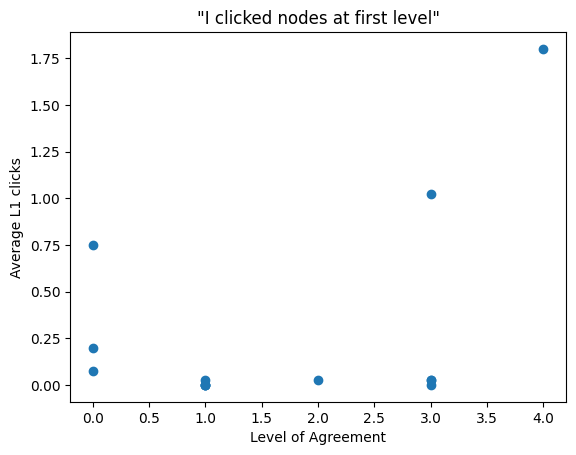

In [61]:
print(strategy_ans_df["Q0"].corr(strategy_ans_df["cL1_mean"]))
plt.scatter(strategy_ans_df["Q0"], strategy_ans_df["cL1_mean"])
plt.title("\"I clicked nodes at first level\"")
plt.xlabel("Level of Agreement")
plt.ylabel("Average L1 clicks")
plt.show()

In [113]:
strategy_ans_df["Q4"].value_counts().sort_index()

Q4
0.0    5
1.0    4
2.0    3
4.0    2
Name: count, dtype: int64

In [156]:
strategy_ans_df.where(strategy_ans_df > 2, 100)

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,3.0,100.0,100.0,100.0,3.0,100.00
1,3.0,100.0,3.0,100.0,3.0,100.00
2,100.0,100.0,3.0,100.0,100.0,100.00
3,4.0,100.0,4.0,4.0,100.0,100.00
4,3.0,100.0,100.0,3.0,100.0,100.00
5,3.0,100.0,100.0,3.0,100.0,100.00
6,100.0,100.0,100.0,100.0,100.0,100.00
8,4.0,100.0,3.0,100.0,3.0,100.00
9,100.0,3.0,100.0,4.0,4.0,100.00
10,100.0,100.0,100.0,3.0,100.0,100.00


In [165]:
agreement_df == 2

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,True,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,False,False,False,True,False
6,False,False,False,False,False,False
8,False,True,False,False,False,False
9,False,False,False,False,False,False
10,False,False,False,False,False,False


In [172]:
agreement_df = strategy_ans_df.copy()
agreement_df = agreement_df.where(agreement_df >= 2, -1)
agreement_df = agreement_df.where(agreement_df <= 2, 1)
agreement_df = agreement_df.where(agreement_df != 2, 0)
agreement_df["cL1_mean"] = strategy_ans_df["cL1_mean"]

agreement_df

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,1.0,-1.0,-1.0,-1.0,1.0,0.12
1,1.0,-1.0,1.0,-1.0,1.0,0.36
2,-1.0,-1.0,1.0,-1.0,0.0,0.04
3,1.0,-1.0,1.0,1.0,-1.0,1.96
4,1.0,-1.0,-1.0,1.0,-1.0,0.00
5,1.0,-1.0,-1.0,1.0,0.0,0.60
6,-1.0,-1.0,-1.0,-1.0,-1.0,0.00
8,1.0,0.0,1.0,-1.0,1.0,0.00
9,-1.0,1.0,-1.0,1.0,1.0,0.28
10,-1.0,-1.0,-1.0,1.0,-1.0,0.00


In [176]:
(agreement_df["Q1"] + agreement_df["Q2"]).value_counts()

 0.0    13
-2.0    10
-1.0     4
 1.0     2
Name: count, dtype: int64

In [85]:
correct_answers = {
    "Q0": "$-2 to $2",
    "Q1": "$-16 to $16",
    "Q2": "$-88 to $88"
}

num_correct = {}
questions_correct = {}
bonus = {}

for cond in conditions.keys():
    num_correct[cond] = []
    questions_correct[cond] = {
        "Q0": 0,
        "Q1": 0,
        "Q2": 0
    }
    bonus[cond] = []
    sub_df = complete_data.loc[complete_data.condition == cond]
    for idx, row in sub_df.iterrows():
        part = [p for p in part_stats_dicts if p["workerId"] == row["workerId"]][0]
        part_answers = part['final_quiz_responses']
        part_correct_answers = sum([part_answers[key] == correct_answers[key] for key in correct_answers.keys()])
        num_correct[cond].append(part_correct_answers)
        for q in correct_answers.keys():
            questions_correct[cond][q] += int(part_answers[q] == correct_answers[q])
        part_bonus = full_bonus_eligible.loc[full_bonus_eligible.workerId == row["workerId"]].bonus.values[0]
        bonus[cond].append(part_bonus)



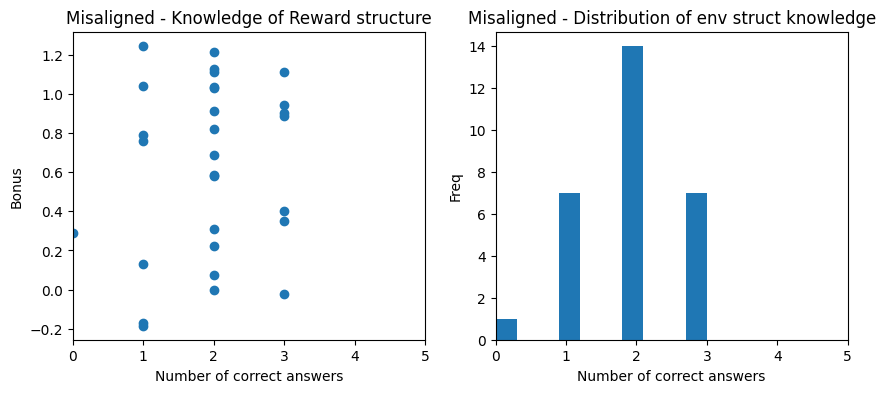

In [86]:


for idx, (cond, condname) in enumerate(conditions.items()):
    plt.figure(figsize=(5 * 2,4 * len(conditions)))
    plt.subplot(1,2,1)
    plt.scatter(num_correct[cond], bonus[cond])
    plt.xlabel("Number of correct answers")
    plt.ylabel("Bonus")
    plt.title(f"{condname} - Knowledge of Reward structure")
    plt.xlim([0,5])
    plt.subplot(1,2,2)
    plt.hist(num_correct[cond])
    plt.xlabel("Number of correct answers")
    plt.ylabel("Freq")
    plt.xlim([0,5])
    plt.title(f"{condname} - Distribution of env struct knowledge")

plt.show()

In [87]:
questions_correct

{0: {'Q0': 20, 'Q1': 13, 'Q2': 23}}